<a href="https://colab.research.google.com/github/Guptaraj06/creditscore/blob/main/CreditScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
pd.set_option('display.max_columns',100)

In [3]:
DECIMALS={
    'USDC':6,
    'WMATIC':18,
    'DAI':18,
    'WBTC':8,
    'WETH':18,
    'USDT':6,
    'WPOL':18,
    'AAVE':18
}

In [4]:
def converter(x):
  try:
    return (x['actionData_amount']/(10**DECIMALS[x['actionData_assetSymbol']]))*x['actionData_assetPriceUSD']
  except Exception as e:
    return 0.0

def calculate_feature(tdf):
  tdf['actionData_amount']=pd.to_numeric(tdf['actionData_amount'],errors='coerce').fillna(0)
  tdf['actionData_assetPriceUSD']=pd.to_numeric(tdf['actionData_assetPriceUSD'],errors='coerce').fillna(0)

  tdf['usd_amount']=0.0

  tdf['usd_amount']=tdf.apply(converter,axis=1)

  grouped=tdf.groupby('userWallet')

  result=pd.DataFrame()

  result['n_deposits']=grouped.apply(lambda x:(x.action=='deposit').sum())

  result['n_borrows']=grouped.apply(lambda x:(x.action=='borrow').sum())

  result['n_repays']=grouped.apply(lambda x:(x.action=='repay').sum())

  result['n_redeems']=grouped.apply(lambda x:(x.action=='redeemunderlying').sum())

  result['n_liquidations']=grouped.apply(lambda x:(x.action=='liquidationcall').sum())

  result['total_deposit']=grouped.apply(lambda x:x.loc[x.action=='deposit','usd_amount'].sum())

  result['total_borrow']=grouped.apply(lambda x:x.loc[x.action=='borrow','usd_amount'].sum())

  result['total_repaid']=grouped.apply(lambda x:x.loc[x.action=='repay','usd_amount'].sum())

  result['total_redeem']=grouped.apply(lambda x:x.loc[x.action=='redeemunderlying','usd_amount'].sum())

  first_ts=grouped['timestamp'].min()

  last_ts=grouped['timestamp'].max()

  result['active_days']=(pd.to_datetime(last_ts,unit='s')-pd.to_datetime(first_ts,unit='s')).apply(lambda x:x.days+1)

  result['txn']=grouped.size()

  result['repay_ratio']=(result['total_repaid']/(result['total_borrow'].replace(0,np.nan))).clip(upper=1).fillna(1)

  result['borrow_ratio']=(result['total_borrow']/(result['total_deposit'].replace(0,np.nan))).clip(upper=1).fillna(0)

  result['avg_txn']=(result['txn']/result['active_days'].replace(0,np.nan)).fillna(0)

  return result


def rep_pref(row):
  if(row['total_borrow']>0):
    if(row['repay_ratio']==1.0):
      return 100
    else:
      return -(1.0 - row['repay_ratio'])*400
  else :
    return 50

def bor_pref(row):
  if(row['total_borrow']>0 and row['total_deposit']>0):
    if(row['borrow_ratio']>0.6):
      return -min((row['borrow_ratio']-0.6)*200,150)
    else:
      return 0
  else :
    return 0

def liq(row):
    return -min(row['n_liquidations']*200,750)

def active_day(row):
  return min(row['active_days']*5,75)

def txn_perf(row):
  if(row['avg_txn']>10):
    return -min((row['avg_txn']-10)*15,50)
  else :
    return 0


def assign_score(df):
  score=pd.Series(500.0,index=df.index,dtype=float)

  score+=df.apply(liq,axis=1)

  score+=df.apply(rep_pref,axis=1)

  score+=df.apply(bor_pref,axis=1)

  score+df.apply(active_day,axis=1)

  score+=df.apply(txn_perf,axis=1)

  score=score.clip(lower=0,upper=1000)

  return score


def generate_wallet_score(path):
  with open(path,'r') as f:
    data=json.load(f)
  df=pd.json_normalize(data,sep='_')

  result=calculate_feature(df)
  result.to_csv('result.csv')
  score=assign_score(result)
  score.to_csv('score.csv',header=['score'])

In [ ]:
generate_wallet_score('/content/drive/MyDrive/data.json')

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor


In [7]:
df=pd.read_csv('/content/result.csv')
df.head()

,userWallet,n_deposits,n_borrows,n_repays,n_redeems,n_liquidations,total_deposit,total_borrow,total_repaid,total_redeem,active_days,txn,repay_ratio,borrow_ratio,avg_txn
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1987.663655,0.000000,0.000000,0.000000,1,1,1.000000,0.00000,1.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,285.694480,0.000000,0.000000,0.000000,1,1,1.000000,0.00000,1.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,0.005152,0.000000,0.000000,0.000000,8,2,1.000000,0.00000,0.250000
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,0.000000,0.000000,0.000000,1960.722952,130,17,1.000000,0.00000,0.130769
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,925490.696960,130355.754756,70150.263791,824037.577815,133,399,0.538145,0.14085,3.000000


In [8]:
score_df=pd.read_csv('/content/score.csv')
score_df.head()

,userWallet,score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,550.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,550.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,550.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,550.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,315.257896


In [9]:
df.describe()

,n_deposits,n_borrows,n_repays,n_redeems,n_liquidations,total_deposit,total_borrow,total_repaid,total_redeem,active_days,txn,repay_ratio,borrow_ratio,avg_txn
count,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3.497000e+03,3.497000e+03,3.497000e+03,3.497000e+03,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000
mean,10.811553,4.885902,3.589648,9.237918,0.070918,1.754967e+05,1.175732e+05,8.891131e+04,1.862643e+05,22.593080,28.595939,0.806132,0.209319,1.674585
std,29.868997,15.133573,13.374770,242.518307,0.692889,2.179518e+06,1.479900e+06,1.187504e+06,2.069756e+06,33.174518,250.732075,0.359804,0.291966,4.530480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.020833
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.061817e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.845336,0.000000,0.489051
50%,2.000000,0.000000,0.000000,0.000000,0.000000,4.803163e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,3.000000,1.000000,0.000000,1.000000
75%,6.000000,3.000000,2.000000,3.000000,0.000000,4.056299e+03,8.997755e+02,4.575458e+02,3.330974e+03,33.000000,16.000000,1.000000,0.399144,2.000000
max,511.000000,200.000000,291.000000,14265.000000,26.000000,6.167728e+07,4.703976e+07,4.690745e+07,6.058051e+07,154.000000,14265.000000,1.000000,1.000000,216.136364


In [10]:
score_df.describe()

,score
count,3497.000000
mean,449.738968
std,178.126202
min,0.000000
25%,402.552607
50%,550.000000
75%,550.000000
max,600.000000


In [11]:
jn_df=pd.concat([df.drop('userWallet',axis=1),score_df.drop('userWallet',axis=1)],axis=1)
jn_df

,n_deposits,n_borrows,n_repays,n_redeems,n_liquidations,total_deposit,total_borrow,total_repaid,total_redeem,active_days,txn,repay_ratio,borrow_ratio,avg_txn,score
0,1,0,0,0,0,1987.663655,0.000000e+00,0.000000,0.000000,1,1,1.000000,0.000000,1.000000,550.000000
1,1,0,0,0,0,285.694480,0.000000e+00,0.000000,0.000000,1,1,1.000000,0.000000,1.000000,550.000000
2,2,0,0,0,0,0.005152,0.000000e+00,0.000000,0.000000,8,2,1.000000,0.000000,0.250000,550.000000
3,0,0,0,17,0,0.000000,0.000000e+00,0.000000,1960.722952,130,17,1.000000,0.000000,0.130769,550.000000
4,250,15,4,130,0,925490.696960,1.303558e+05,70150.263791,824037.577815,133,399,0.538145,0.140850,3.000000,315.257896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,1,0,0,0,0,0.000099,0.000000e+00,0.000000,0.000000,1,1,1.000000,0.000000,1.000000,550.000000
3493,4,1,0,2,0,22.642876,2.330736e+00,0.000000,16.046172,1,7,0.000000,0.102935,7.000000,100.000000
3494,1,0,0,4,0,35309.766244,0.000000e+00,0.000000,70586.392081,1,5,1.000000,0.000000,5.000000,550.000000
3495,13,2,2,5,0,6813.240971,1.202218e+03,199.896161,812.649923,32,22,0.166273,0.176453,0.687500,166.509125


In [12]:
jn_df.shape

(3497, 15)

In [13]:
jn_df.columns

Index(['n_deposits', 'n_borrows', 'n_repays', 'n_redeems', 'n_liquidations',
       'total_deposit', 'total_borrow', 'total_repaid', 'total_redeem',
       'active_days', 'txn', 'repay_ratio', 'borrow_ratio', 'avg_txn',
       'score'],
      dtype='object')

In [14]:
plot_cols = [col for col in df.columns if col != 'userWallet'][:15]

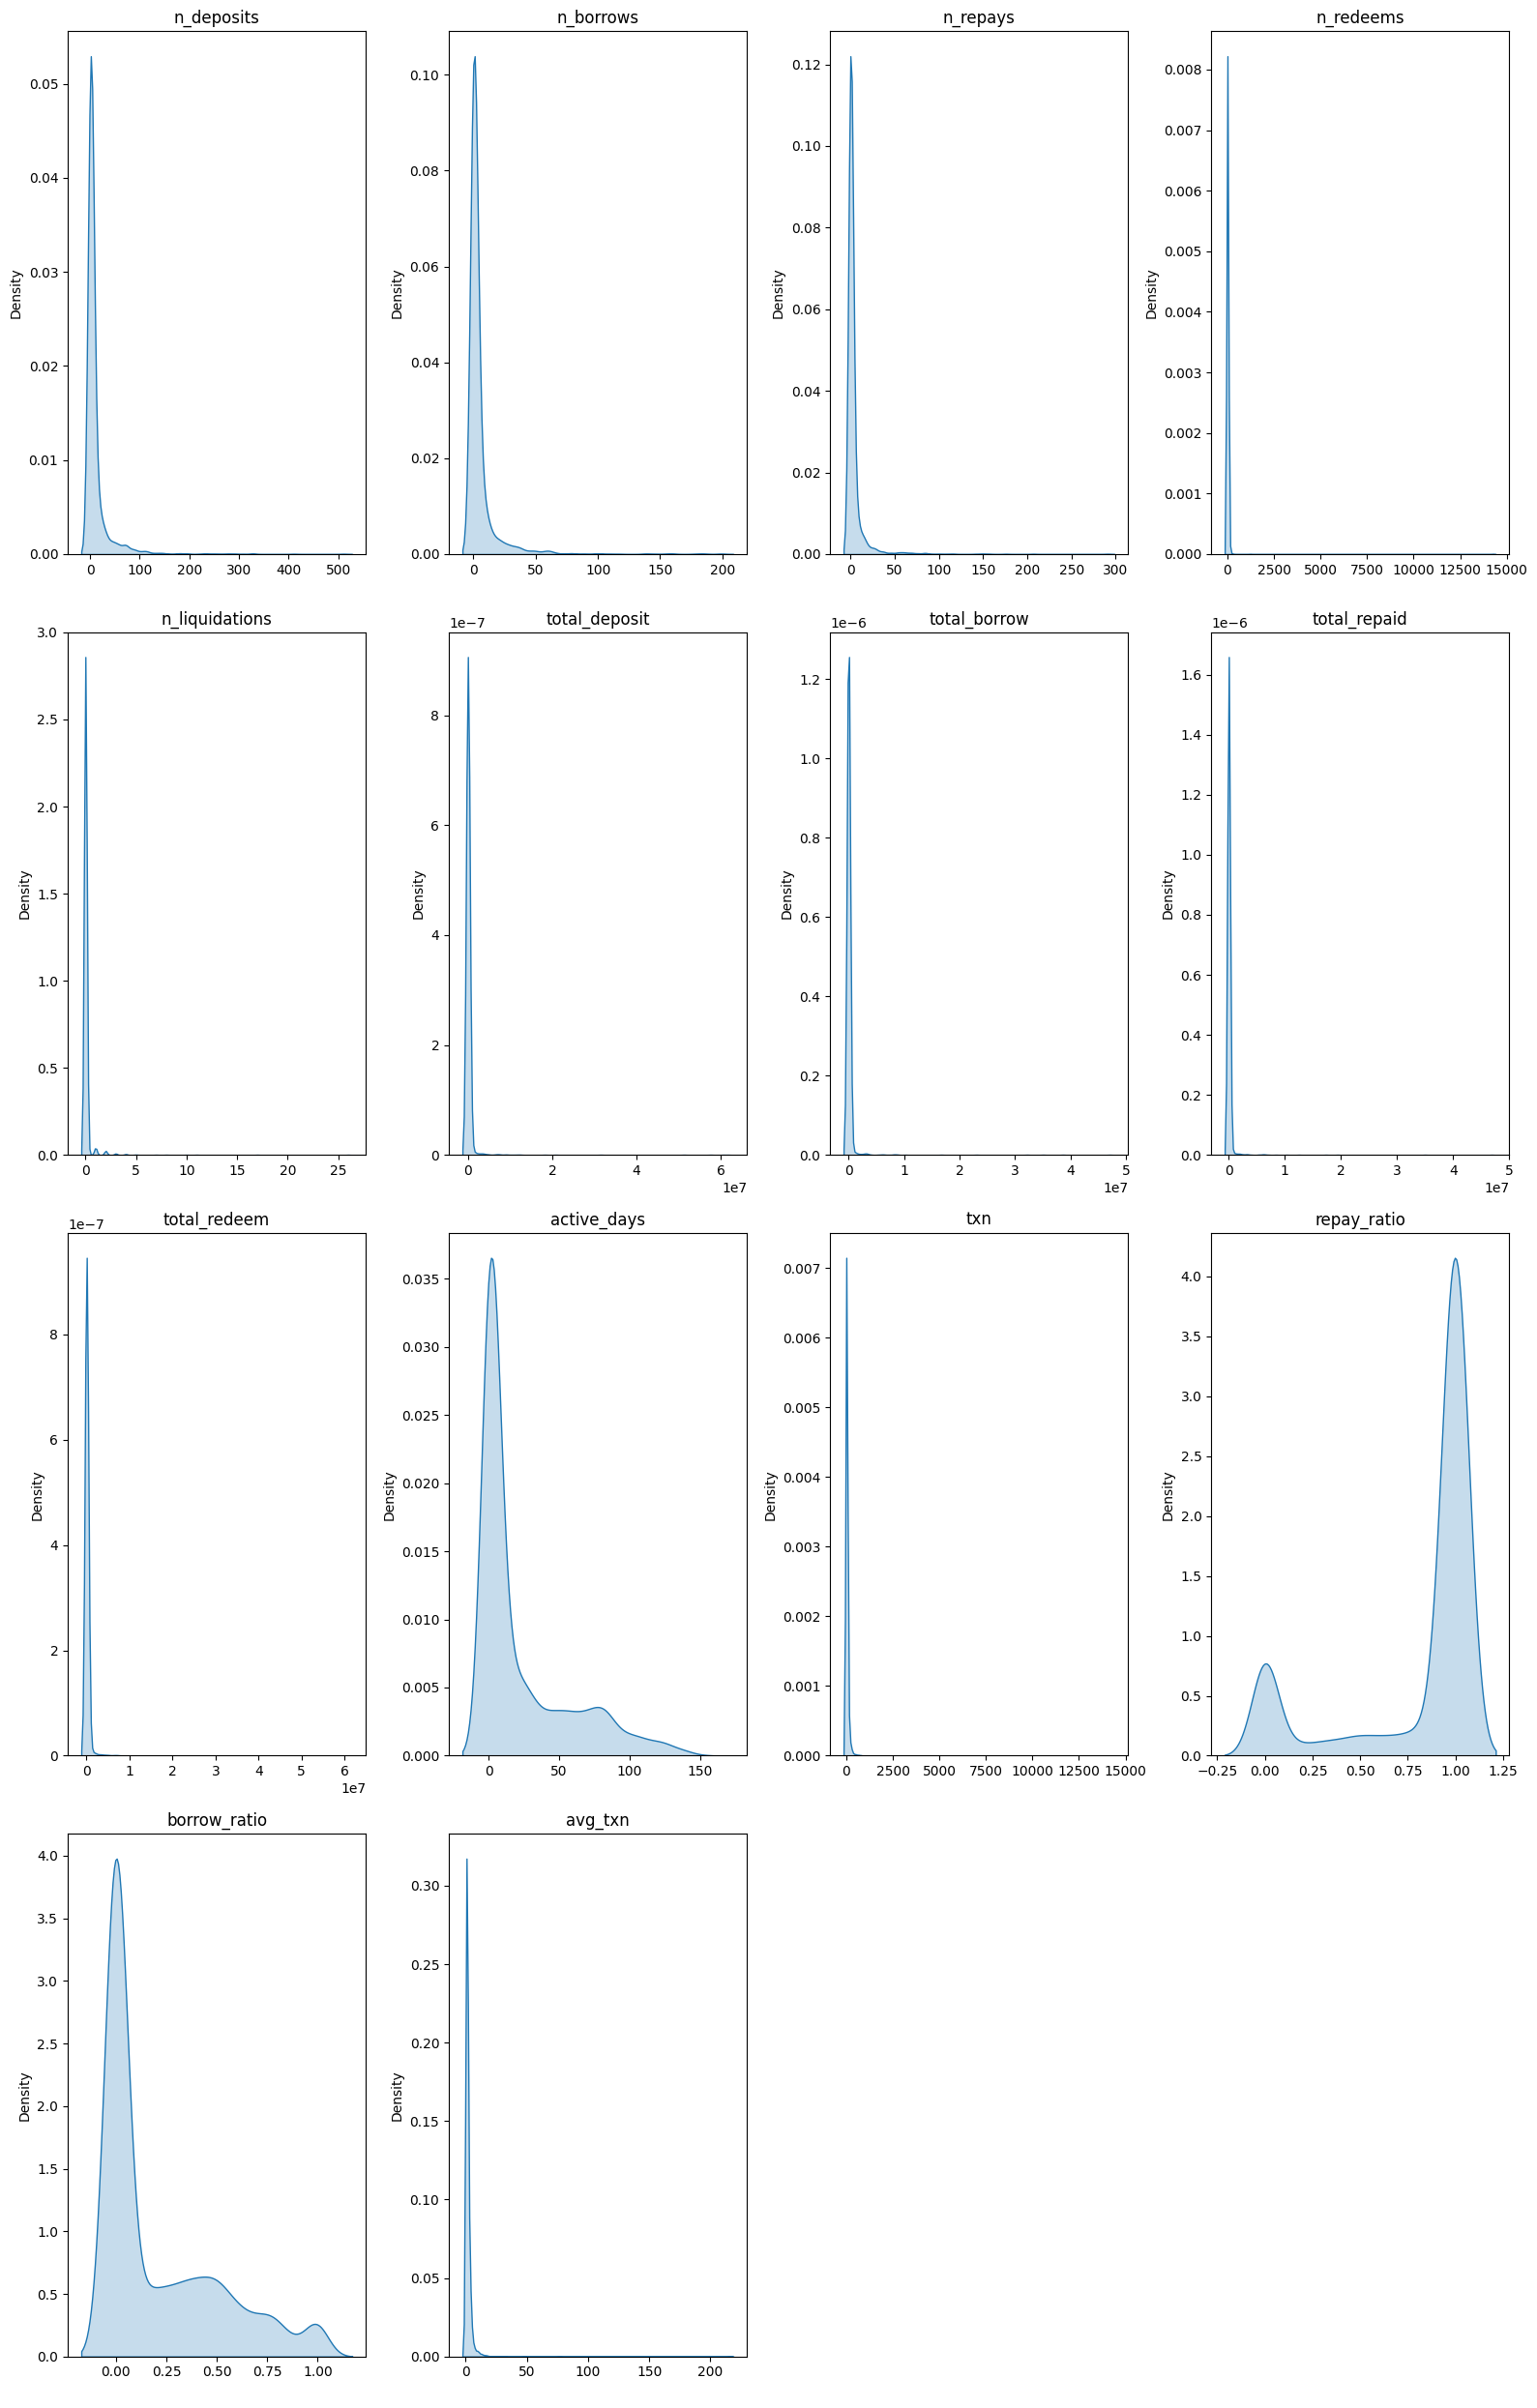

In [15]:
fig,ax=plt.subplots(4,4,figsize=(16,25))
ax=ax.flatten()

for i,col in enumerate(plot_cols):
  sns.kdeplot(jn_df[col],ax=ax[i],fill=True)
  ax[i].set_title(col,fontsize=12)
  ax[i].set_xlabel(' ')
  ax[i].tick_params(axis='both',which='major',labelsize=10)

for j in range(len(plot_cols),16):
  ax[j].axis('off')

plt.tight_layout()
plt.show()




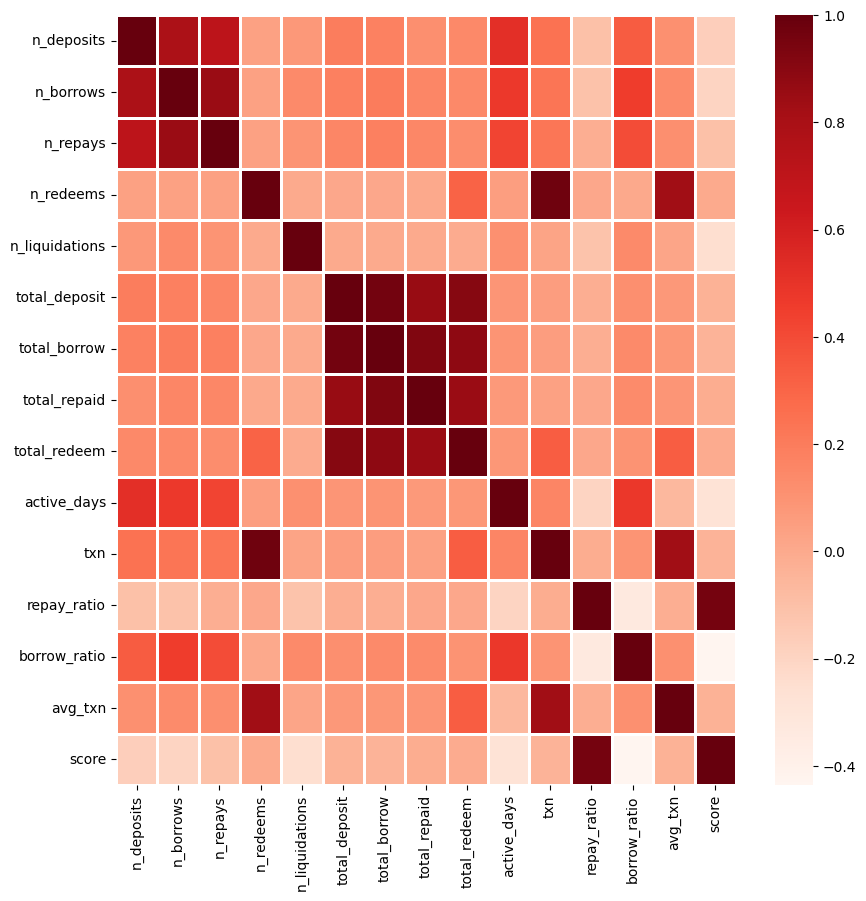

In [16]:
corr=jn_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidth=1,cmap='Reds')
plt.show()


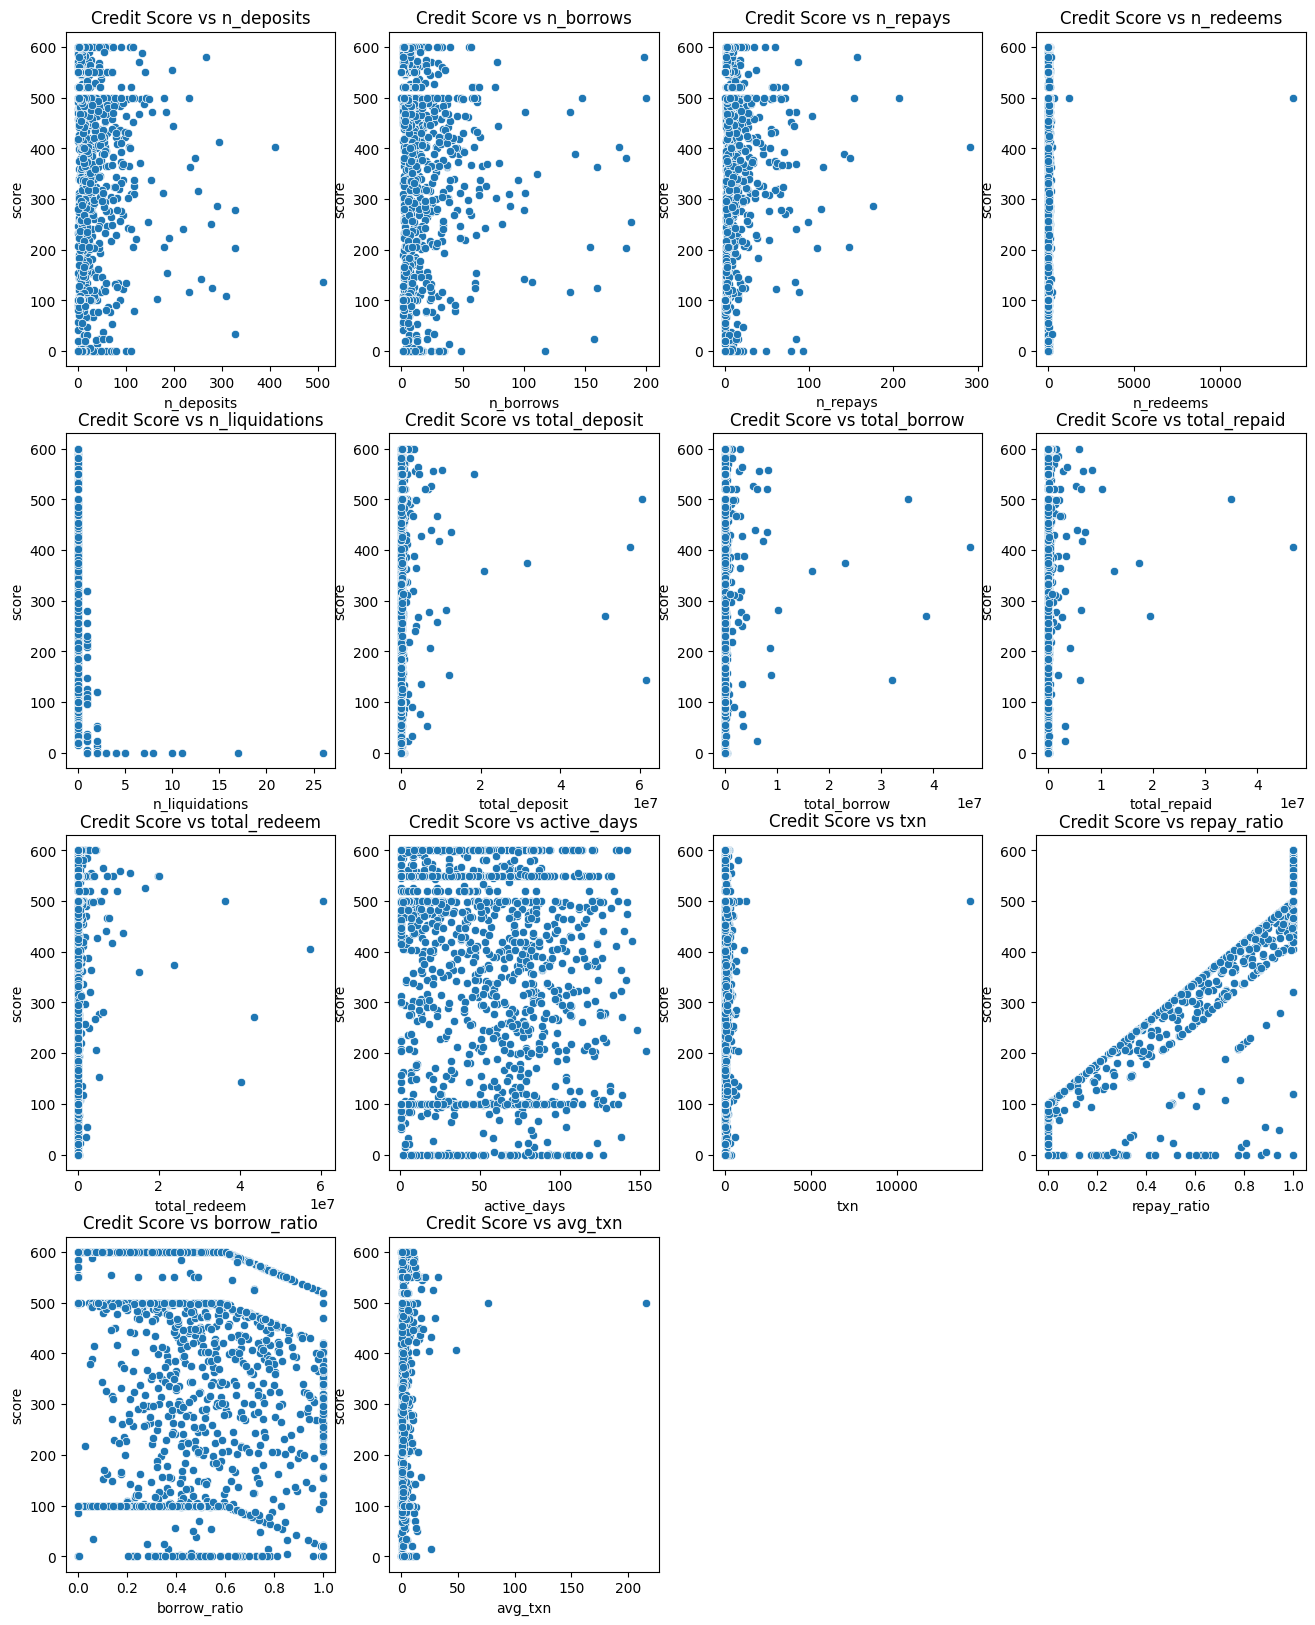

In [17]:
fig,ax=plt.subplots(4,4,figsize=(16,20))
ax=ax.flatten()
for i,col in enumerate(plot_cols):
    sns.scatterplot(ax=ax[i],x=col, y='score',data=jn_df)
    ax[i].set_title(f"Credit Score vs {col}")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('score')
    ax[i].tick_params(axis='both',which='major',labelsize=10)

for j in range(len(plot_cols),16):
  ax[j].axis('off')

plt.show()

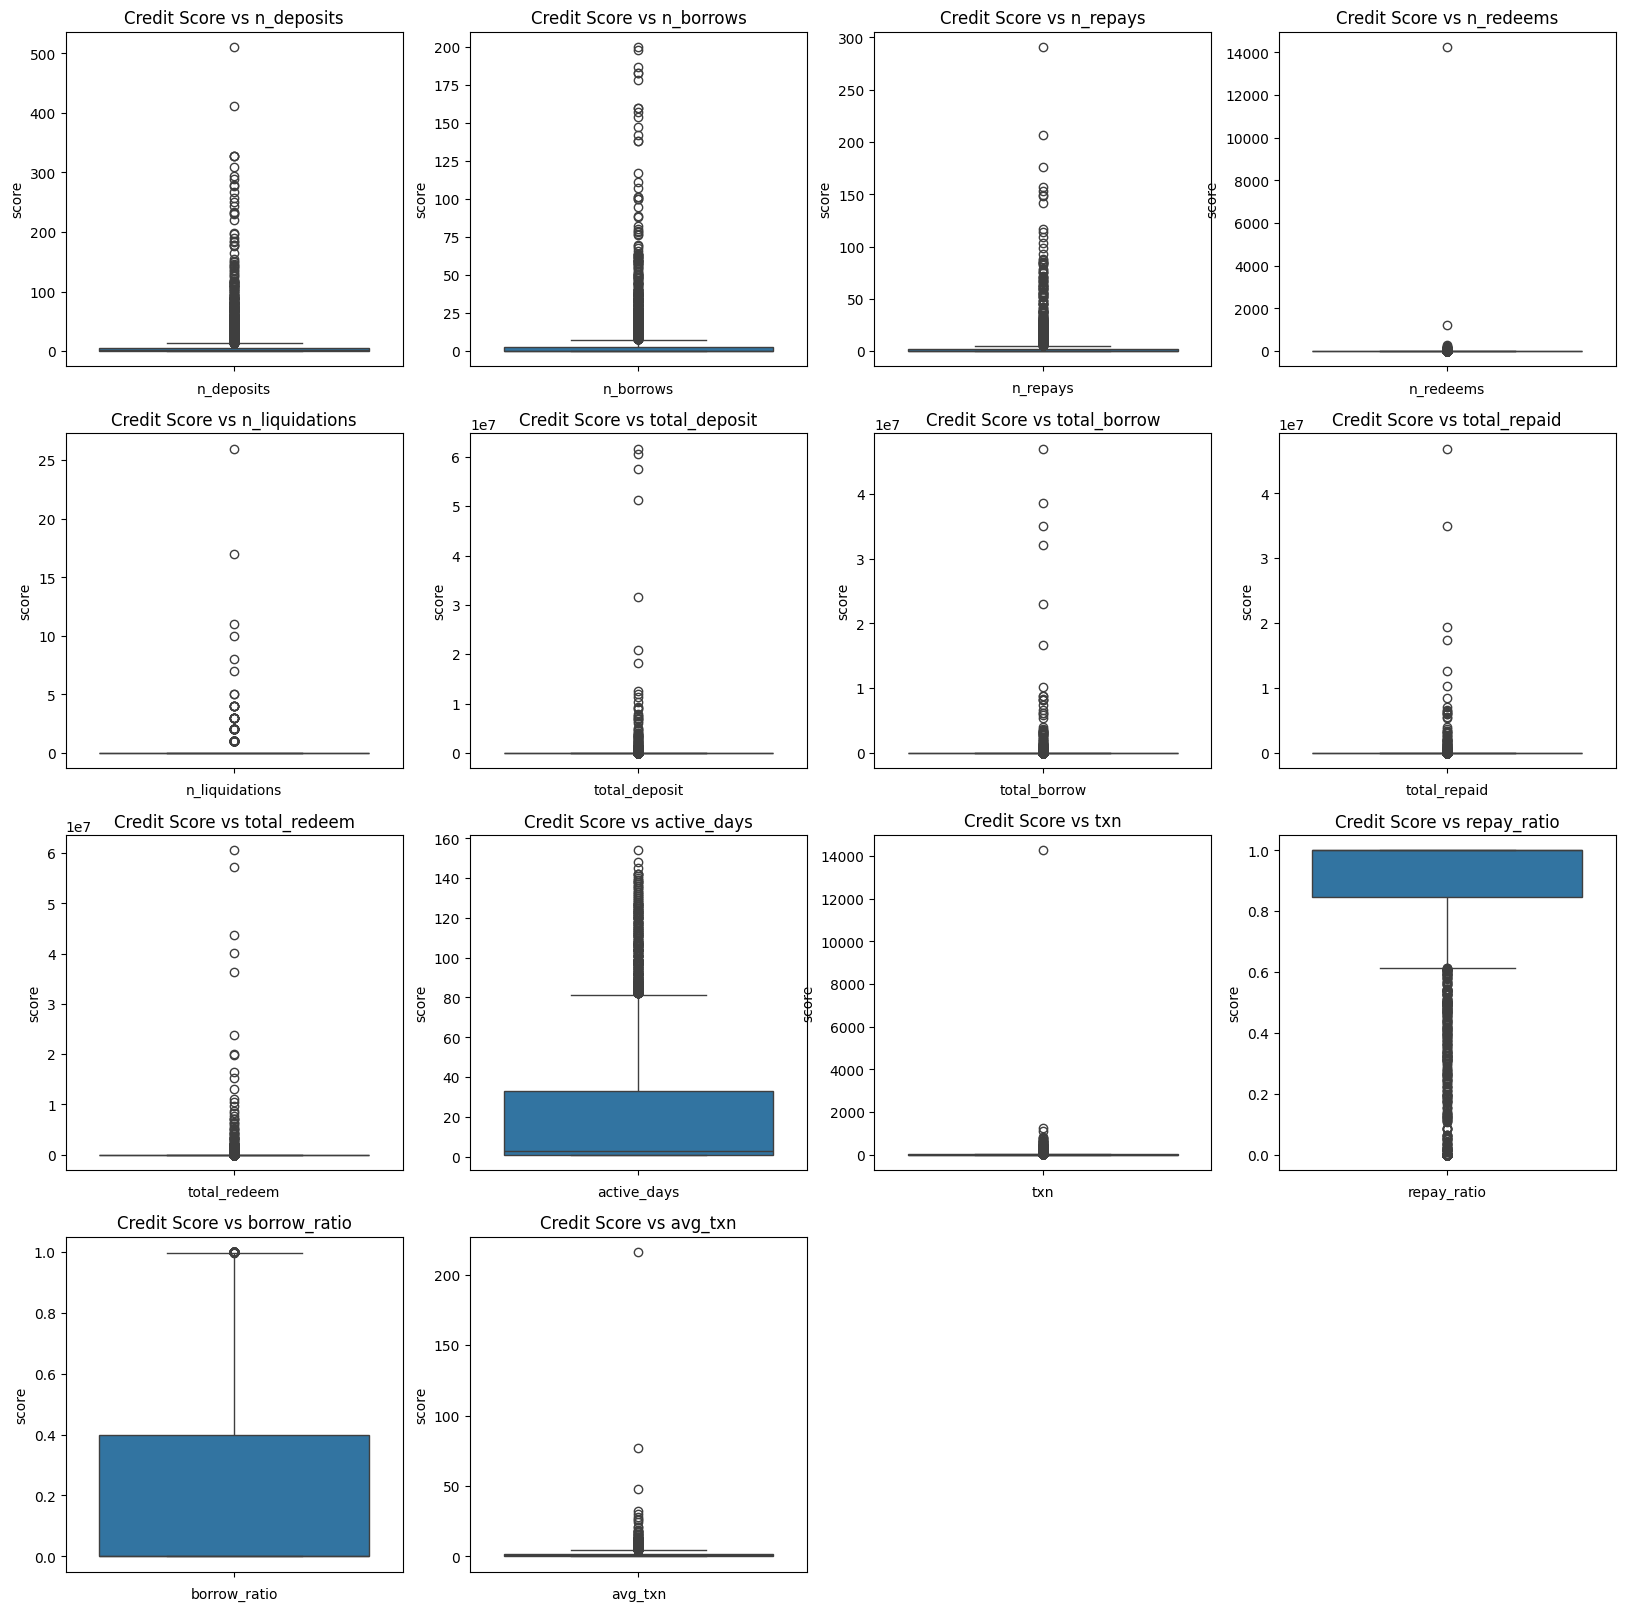

In [18]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
ax=ax.flatten()
for i,col in enumerate(plot_cols):
    sns.boxplot(jn_df[col],ax=ax[i])
    ax[i].set_title(f"Credit Score vs {col}")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('score')
    ax[i].tick_params(axis='both',which='major',labelsize=10)

for j in range(len(plot_cols),16):
  ax[j].axis('off')

plt.show()

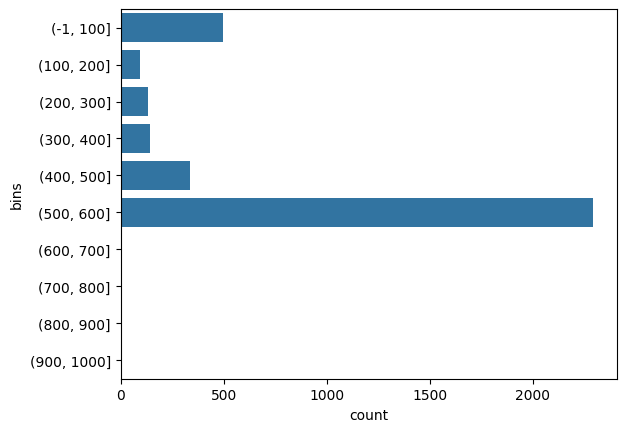

In [19]:
jn_df['bins']=pd.cut(jn_df['score'],bins=[-1,100,200,300,400,500,600,700,800,900,1000])
sns.countplot(jn_df['bins'])
plt.show()

In [22]:
jn_df['bins'].value_counts()

,count
bins,
"(500, 600]",2291
"(-1, 100]",497
"(400, 500]",339
"(300, 400]",144
"(200, 300]",132
"(100, 200]",94
"(600, 700]",0
"(700, 800]",0
"(800, 900]",0


In [20]:
X=jn_df.copy()
X=X.drop(['score','bins'],axis=1)
Y=jn_df['score']

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [22]:
rf=RandomForestRegressor(n_estimators=200,max_depth=10,random_state=42,n_jobs=-1)

In [23]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [24]:
y_pred=rf.predict(X_test)


In [25]:
print("RMSE :",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 score:",r2_score(y_test,y_pred))

RMSE : 5.433867049628204
R2 score: 0.9990929465322228


In [26]:
feature=list(X_train.columns)
feature

['n_deposits',
 'n_borrows',
 'n_repays',
 'n_redeems',
 'n_liquidations',
 'total_deposit',
 'total_borrow',
 'total_repaid',
 'total_redeem',
 'active_days',
 'txn',
 'repay_ratio',
 'borrow_ratio',
 'avg_txn']

/tmp/ipython-input-27-1970282868.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


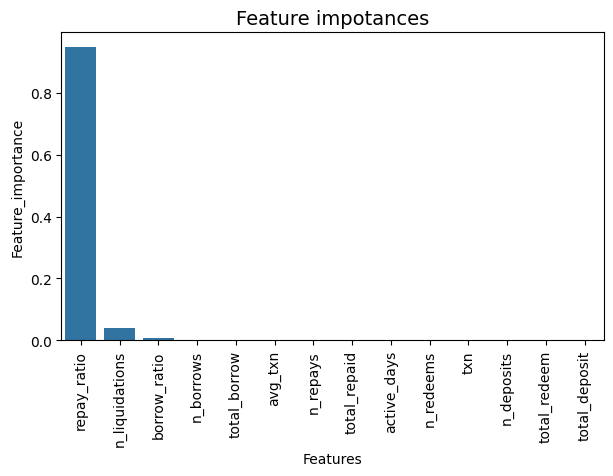

In [27]:
tmp=pd.DataFrame({'Features': feature,'Feature_importance': rf.feature_importances_})
tmp=tmp.sort_values(by='Feature_importance',ascending=False)
plt.figure(figsize=(7,4))
plt.title('Feature impotances',fontsize=14)
s=sns.barplot(x='Features',y='Feature_importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [28]:
import lightgbm as lgb
from lightgbm import early_stopping,log_evaluation

In [44]:
lgm=lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    min_child_samples=100,
)

In [45]:
lgm.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric="rmse",callbacks=[early_stopping(50),log_evaluation(100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 2797, number of used features: 13
[LightGBM] [Info] Start training from score 451.230735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor(learning_rate=0.05, max_depth=10, min_child_samples=100,
              n_estimators=500, n_jobs=-1, random_state=42)

In [46]:
y_pred=lgm.predict(X_test)
print("rmse:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 score:",r2_score(y_test,y_pred))

rmse: 37.11701887514938
r2 score: 0.9576785004999127


/tmp/ipython-input-32-364939361.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


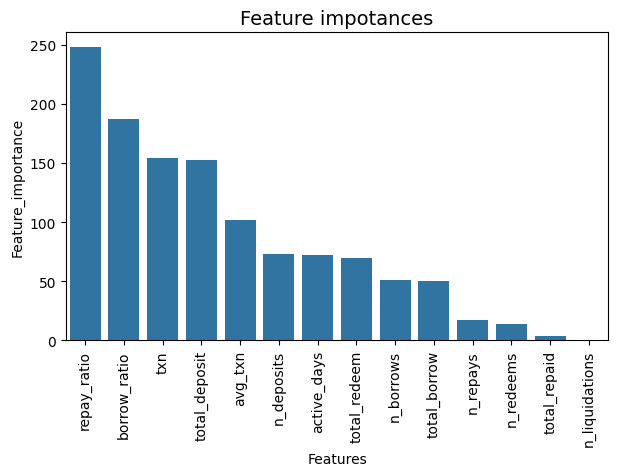

In [32]:
tmp=pd.DataFrame({'Features': feature,'Feature_importance': lgm.feature_importances_})
tmp=tmp.sort_values(by='Feature_importance',ascending=False)
plt.figure(figsize=(7,4))
plt.title('Feature impotances',fontsize=14)
s=sns.barplot(x='Features',y='Feature_importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [33]:
import tensorflow as tf
from keras import models
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
model=Sequential([
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1,activation='relu')
])
earlystopping=EarlyStopping(monitor='val_loss',patience=35,restore_best_weights=True)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=['mae'])
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=512,epochs=300,verbose=1,callbacks=[earlystopping])

Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 641ms/step - loss: 192784.1875 - mae: 408.1483 - val_loss: 161130.4531 - val_mae: 362.6265
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 192138.6875 - mae: 407.9395 - val_loss: 160627.1875 - val_mae: 361.9755
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 193061.9062 - mae: 410.3016 - val_loss: 160064.4375 - val_mae: 361.2432
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 190330.0156 - mae: 405.8390 - val_loss: 159486.2812 - val_mae: 360.4923
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 190937.8125 - mae: 407.4420 - val_loss: 158909.4844 - val_mae: 359.7459
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 188134.7812 - mae: 403.1997 - val_loss: 158401.4844 - val_mae: 359.0910
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 189221.2812 - mae: 404.9080 - val_loss: 157631.6875 - val_mae: 358.0944
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 187621.4688 - mae: 402.7866 - v

In [40]:
y_preds=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [43]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_preds)))
print("R2 :", r2_score(y_test, y_pred))


RMSE: 402.1297260288294
R2 : 0.9576785004999127
